# DETECTING RECON ATTACKS ON IOT DEVICES

### THE PROBLEM

As our infrastructures, services and products become ever more reliant on IoT networks, securing the networks through dection is becoming increasingly important.


### THE PROJECT OBJECTIVE

Our aim is to develop and test different models to analyze IoT network traffic in order to detect and classify Recon Attacks, a specific kind of cyberattack.


### THE DATASET

The CICIOT2023 dataset from West Brunwick University consists in a collection of csv files containing data generated by the traffic monitoring (perfromed through wireshark) of an IoT smart home network.

The network is reproduced in a lab and consists of 105 IoT devices. In order to gather network traffic data from actual different kinds of cyberattacks, 33 different cyberattack has been performed on the network and its devices.

Such devices are divided into three categories:

- Victims (67 devices from all over the nework)
- Attackers (10 devices, mainly raspberry Pi 4s)
- Passives (28 devices not involved in the attacks)

Thanks to the way the network is arranged the researchers were able to label the data with the kind of cyberattack being performed.
Subsequently the data was aggregated from .pcap files into a set of .csv files.
The end result is a large dataset with 47 features and more than 40 million rows.


### CURRENT NOTEBOOK SCOPE


This work will focus on developing deep learning models in order to identify 5 kinds of Recon attacks, attacks meant to identify the network vulnerability.
We are interested in this kind as they are the typical first step of the most sophisticated and dangerous kinds of attack.

This notebook aims at pre-processing and cleaning the data in order to conduct EDA.


As always we start by importing the necessary modules. I am importing polars in case heavy computations are needed.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl
import os

### Extracting the relevant data from csv files


Now, we know from previous exploration that we have 34 labels. For EDA purposes we should remap them in 5 kinds:

- Benign Traffic
- DDoS attacks
- DoS attacks
- Mirai attacks
- Spoofing attacks
- Web attacks
- Brute Force attacks
- Recon attacks

The following table breaks down the categories:

| Attack Category    | Attack Objective                                  | Entry Points                | Expected Network Traffic Change |
|--------------------|---------------------------------------------------|-----------------------------|---------------------------------|
| Benign Traffic     | Normal network operations                         | Various                     | No significant change          |
| DDoS Attacks       | Disrupt service by overwhelming resources         | Network interfaces          | Significant increase           |
| DoS Attacks        | Disrupt service to a server or network            | Network interfaces          | Sudden spike or drop           |
| Mirai Attacks      | Exploit IoT devices for large-scale attacks       | IoT devices                 | Varied, often increased        |
| Spoofing Attacks   | Impersonate devices or users                      | Network interfaces, devices | Varied, potential increase     |
| Web Attacks        | Exploit web services vulnerabilities              | Web servers, applications   | Varied, often targeted         |
| Brute Force Attacks| Crack passwords through trial and error          | Authentication systems      | Varied, often increased        |
| Recon Attacks      | Gather information about network and vulnerabilities | Network scanning, probing | Minor, but patterned increase  |


We know from the litterature on the dataset that previous modelling attempts were very good at detecting DDoS and DoS attacks.

This is why we focus on Recon attacks.

To do so we have to extract relevant data from the 126 .csv files and create a single data frame.

Let's first take a sample from these:

In [4]:
# Creating list of csv files 
directory = r"C:\Users\dfuma\Documents\cybersec_cap\data\wataiData\csv\CICIoT2023"
csv_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]

# Taking one sample
sample_df = pd.read_csv(r"C:\Users\dfuma\Documents\cybersec_cap\data\wataiData\csv\CICIoT2023\part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")
sample_df.columns

Index(['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label'],
      dtype='object')

Now we have to make sure the data types will stay the same while we append each chunk to the combined data frame.

In [39]:
# Create dictionary with column and data type
d_types = {k: v.name for k, v in zip(sample_df.columns,sample_df.dtypes)}

d_types

{'flow_duration': 'float64',
 'Header_Length': 'float64',
 'Protocol Type': 'float64',
 'Duration': 'float64',
 'Rate': 'float64',
 'Srate': 'float64',
 'Drate': 'float64',
 'fin_flag_number': 'float64',
 'syn_flag_number': 'float64',
 'rst_flag_number': 'float64',
 'psh_flag_number': 'float64',
 'ack_flag_number': 'float64',
 'ece_flag_number': 'float64',
 'cwr_flag_number': 'float64',
 'ack_count': 'float64',
 'syn_count': 'float64',
 'fin_count': 'float64',
 'urg_count': 'float64',
 'rst_count': 'float64',
 'HTTP': 'float64',
 'HTTPS': 'float64',
 'DNS': 'float64',
 'Telnet': 'float64',
 'SMTP': 'float64',
 'SSH': 'float64',
 'IRC': 'float64',
 'TCP': 'float64',
 'UDP': 'float64',
 'DHCP': 'float64',
 'ARP': 'float64',
 'ICMP': 'float64',
 'IPv': 'float64',
 'LLC': 'float64',
 'Tot sum': 'float64',
 'Min': 'float64',
 'Max': 'float64',
 'AVG': 'float64',
 'Std': 'float64',
 'Tot size': 'float64',
 'IAT': 'float64',
 'Number': 'float64',
 'Magnitue': 'float64',
 'Radius': 'float64',


Now let's use this data type read each csv. Subsequently we will filter on the labels that we need: those whith benign traffic and those with the 5 kinds of recon attacks.

In [42]:
# Initialize empty df
combined_df = pd.DataFrame()


# List the labels that we need from each csv file
labels_select = ['Recon-PingSweep', 'Recon-OSScan', 'Recon-PortScan', 'VulnerabilityScan', 'Recon-HostDiscovery', 'BenignTraffic']

# Loop over the list of csv file
for file_path in csv_files:
    df = pd.read_csv(file_path, dtype=d_types, low_memory=False) # read the data with d_types

    # Filter based on the selected labels
    filtered_df = df[df['label'].isin(labels_select)]

    # append to combined_df
    combined_df = pd.concat([combined_df, filtered_df], ignore_index=True)



In [43]:
# Check the result
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452760 entries, 0 to 1452759
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1452760 non-null  float64
 1   Header_Length    1452760 non-null  float64
 2   Protocol Type    1452760 non-null  float64
 3   Duration         1452760 non-null  float64
 4   Rate             1452760 non-null  float64
 5   Srate            1452760 non-null  float64
 6   Drate            1452760 non-null  float64
 7   fin_flag_number  1452760 non-null  float64
 8   syn_flag_number  1452760 non-null  float64
 9   rst_flag_number  1452760 non-null  float64
 10  psh_flag_number  1452760 non-null  float64
 11  ack_flag_number  1452760 non-null  float64
 12  ece_flag_number  1452760 non-null  float64
 13  cwr_flag_number  1452760 non-null  float64
 14  ack_count        1452760 non-null  float64
 15  syn_count        1452760 non-null  float64
 16  fin_count        1

In [44]:
# Check shape
combined_df.shape[0]

1452760

In [45]:
# Check NAs, we expect 0
combined_df.isna().sum()

flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
label              0
dtype: int64

In [46]:
# Check for duplicates (we expect very few)
combined_df.duplicated().sum()

5

In [47]:
# Remove duplicates: df
df = combined_df.drop_duplicates()

In [48]:
df.duplicated().sum()

0

In [49]:
df.shape

(1452755, 47)

In [51]:
# Clear memory
del combined_df

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452755 entries, 0 to 1452759
Data columns (total 47 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1452755 non-null  float64
 1   Header_Length    1452755 non-null  float64
 2   Protocol Type    1452755 non-null  float64
 3   Duration         1452755 non-null  float64
 4   Rate             1452755 non-null  float64
 5   Srate            1452755 non-null  float64
 6   Drate            1452755 non-null  float64
 7   fin_flag_number  1452755 non-null  float64
 8   syn_flag_number  1452755 non-null  float64
 9   rst_flag_number  1452755 non-null  float64
 10  psh_flag_number  1452755 non-null  float64
 11  ack_flag_number  1452755 non-null  float64
 12  ece_flag_number  1452755 non-null  float64
 13  cwr_flag_number  1452755 non-null  float64
 14  ack_count        1452755 non-null  float64
 15  syn_count        1452755 non-null  float64
 16  fin_count        145275

Now let's change the data types for better efficiency

In [52]:
dtypes = {
        'flow_duration': np.float32,
        'Header_Length': np.uint32,
        'Protocol Type': str,
        'Duration': np.float32,
        'Rate': np.uint32,
        'Srate': np.uint32,
        'Drate': np.float32,
        'fin_flag_number': np.bool_,
        'syn_flag_number': np.bool_,
        'rst_flag_number': np.bool_,
        'psh_flag_number': np.bool_,
        'ack_flag_number': np.bool_,
        'ece_flag_number': np.bool_,
        'cwr_flag_number': np.bool_,
        'ack_count': np.float16,
        'syn_count': np.float16,
        'fin_count': np.uint16,
        'urg_count': np.uint16, 
        'rst_count': np.uint16, 
        'HTTP': np.bool_, 
        'HTTPS': np.bool_, 
        'DNS': np.bool_, 
        'Telnet': np.bool_,
        'SMTP': np.bool_, 
        'SSH': np.bool_, 
        'IRC': np.bool_, 
        'TCP': np.bool_, 
        'UDP': np.bool_, 
        'DHCP': np.bool_, 
        'ARP': np.bool_, 
        'ICMP': np.bool_, 
        'IPv': np.bool_, 
        'LLC': np.bool_,
        'Tot sum': np.float32, 
        'Min': np.float32, 
        'Max': np.float32, 
        'AVG': np.float32, 
        'Std': np.float32, 
        'Tot size': np.float32, 
        'IAT': np.float32, 
        'Number': np.float32,
        'Magnitue': np.float32, 
        'Radius': np.float32, 
        'Covariance': np.float32, 
        'Variance': np.float32, 
        'Weight': np.float32, 
        'label': str
    }

# Define function to change data type and adjust formatting

def convert_dtype(df):
    # Adjust data type
    for col,typ in dtypes.items():
        df[col] = df[col].astype(typ)   
    
    # Format column names to lowercase snake
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    # Fix spelling error in original dataset
    df['magnitude'] = df['magnitue']
    return df.drop(['magnitue'], axis=1)


# call the function
convert_dtype(df)

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,radius,covariance,variance,weight,label,magnitude
0,37.887028,1687747,9.3,63.500000,34,34,0.0,False,False,False,...,332.122437,817.500000,5.235219e-03,5.5,469.692078,2.092362e+05,0.9,38.500000,BenignTraffic,24.333355
1,48.272385,128041,10.4,97.800003,39966,39966,0.0,False,False,False,...,694.907043,636.400024,1.665200e+08,13.5,983.968323,4.842123e+05,1.0,244.600006,BenignTraffic,36.393288
2,48.095661,101026,8.8,137.699997,13,13,0.0,False,False,False,...,1302.117188,919.299988,2.724581e-02,5.5,1841.471802,2.063959e+06,0.9,38.500000,BenignTraffic,47.214172
3,46.342407,1301464,4.8,168.300003,34,34,0.0,False,False,False,...,0.428562,64.800003,3.804951e-02,5.5,0.606078,9.315556e-01,0.2,38.500000,BenignTraffic,11.472816
4,88.807747,5290348,7.1,63.599998,61,61,0.0,False,False,False,...,101.938538,1227.300049,1.833391e-03,5.5,144.162857,5.276998e+04,0.2,38.500000,BenignTraffic,54.184532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452755,0.732928,2250732,6.0,93.500000,2782,2782,0.0,False,False,False,...,836.076416,917.599976,8.809566e-05,5.5,1182.390625,8.859554e+05,0.8,38.500000,BenignTraffic,38.208549
1452756,13.401717,11497,6.0,59.200001,11,11,0.0,False,False,False,...,64.519730,108.199997,9.288311e-03,5.5,91.244675,4.696484e+03,0.9,38.500000,BenignTraffic,14.697835
1452757,9.528511,116067,12.6,82.699997,17,17,0.0,False,False,False,...,187.924698,337.500000,1.846900e-02,5.5,265.765656,6.190794e+04,0.9,38.500000,BenignTraffic,19.810381
1452758,16.250675,85094,8.8,103.400002,15,15,0.0,False,False,False,...,857.873474,105.800003,1.665168e+08,13.5,1215.209839,7.409860e+05,1.0,244.600006,BenignTraffic,34.988182


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452755 entries, 0 to 1452759
Data columns (total 48 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   flow_duration    1452755 non-null  float32
 1   header_length    1452755 non-null  uint32 
 2   protocol_type    1452755 non-null  object 
 3   duration         1452755 non-null  float32
 4   rate             1452755 non-null  uint32 
 5   srate            1452755 non-null  uint32 
 6   drate            1452755 non-null  float32
 7   fin_flag_number  1452755 non-null  bool   
 8   syn_flag_number  1452755 non-null  bool   
 9   rst_flag_number  1452755 non-null  bool   
 10  psh_flag_number  1452755 non-null  bool   
 11  ack_flag_number  1452755 non-null  bool   
 12  ece_flag_number  1452755 non-null  bool   
 13  cwr_flag_number  1452755 non-null  bool   
 14  ack_count        1452755 non-null  float16
 15  syn_count        1452755 non-null  float16
 16  fin_count        145275

In order to perform EDA we need change protocol types in a format that is human readable. Right now they are a float indicating the protocol type. We will turn that into an integer and apply a mapping with the description of the protocol type using IANA (Internet Assigned Numbers Authority) protocol numbers.

In [70]:
# Map IANA Protocol numbers to strings (leave user option to 1-hot or numerically encode)
iana_map = { 
    "0": "HOPOPT", "1": "ICMP", "2": "IGMP", "3": "GGP", "4": "IPv4", "5": "ST", 
    "6": "TCP", "7": "CBT", "8": "EGP", "9": "IGP", "10": "BBN-RCC-MON", "11": "NVP-II", 
    "12": "PUP", "13": "ARGUS (deprecated)", "14": "EMCON", "15": "XNET", "16": "CHAOS", 
    "17": "UDP", "18": "MUX", "19": "DCN-MEAS", "20": "HMP", "21": "PRM", "22": "XNS-IDP", 
    "23": "TRUNK-1", "24": "TRUNK-2", "25": "LEAF-1", "26": "LEAF-2", "27": "RDP", 
    "28": "IRTP", "29": "ISO-TP4", "30": "NETBLT", "31": "MFE-NSP", "32": "MERIT-INP", 
    "33": "DCCP", "34": "3PC", "35": "IDPR", "36": "XTP", "37": "DDP", "38": "IDPR-CMTP", 
    "39": "TP++", "40": "IL", "41": "IPv6", "42": "SDRP", "43": "IPv6-Route", 
    "44": "IPv6-Frag", "45": "IDRP", "46": "RSVP", "47": "GRE", "48": "DSR", "49": "BNA", 
    "50": "ESP", "51": "AH", "52": "I-NLSP", "53": "SWIPE (deprecated)", "54": "NARP", 
    "55": "MOBILE", "56": "TLSP", "57": "SKIP", "58": "IPv6-ICMP", "59": "IPv6-NoNxt", 
    "60": "IPv6-Opts", "62": "CFTP", "64": "SAT-EXPAK", "65": "KRYPTOLAN", "66": "RVD", 
    "67": "IPPC", "69": "SAT-MON", "70": "VISA", "71": "IPCV", "72": "CPNX", "73": "CPHB", 
    "74": "WSN", "75": "PVP", "76": "BR-SAT-MON", "77": "SUN-ND", "78": "WB-MON", 
    "79": "WB-EXPAK", "80": "ISO-IP", "81": "VMTP", "82": "SECURE-VMTP", "83": "VINES", 
    "84": "IPTM", "85": "NSFNET-IGP", "86": "DGP", "87": "TCF", "88": "EIGRP", 
    "89": "OSPFIGP", "90": "Sprite-RPC", "91": "LARP", "92": "MTP", "93": "AX.25", 
    "94": "IPIP", "95": "MICP (deprecated)","96": "SCC-SP", "97": "ETHERIP", "98": "ENCAP", 
    "100": "GMTP", "101": "IFMP", "102": "PNNI", "103": "PIM", "104": "ARIS", "105": "SCPS", 
    "106": "QNX", "107": "A/N", "108": "IPComp", "109": "SNP", "110": "Compaq-Peer", 
    "111": "IPX-in-IP", "112": "VRRP", "113": "PGM", "114": "", "115": "L2TP", "116": "DDX",  
    "117": "IATP", "118": "STP", "119": "SRP", "120": "UTI", "121": "SMP", 
    "122": "SM (deprecated)", "123": "PTP","124": "ISIS over IPv4", "125": "FIRE", 
    "126": "CRTP", "127": "CRUDP", "128": "SSCOPMCE", "129": "IPLT", "130": "SPS", 
    "131": "PIPE", "132": "SCTP",  "133": "FC", "134": "RSVP-E2E-IGNORE", 
    "135": "Mobility Header", "136": "UDPLite", "137": "MPLS-in-IP", "138": "manet", 
    "139": "HIP", "140": "Shim6", "141": "WESP", "142": "ROHC", "143": "Ethernet", 
    "144": "AGGFRAG", "145": "NSH"
}

# transform the column protocol type

df['protocol_type'] = df['protocol_type'].apply(lambda x: iana_map[str(int(float(x)))])

set(df['protocol_type'])

{'ARGUS (deprecated)',
 'BBN-RCC-MON',
 'CBT',
 'CHAOS',
 'EGP',
 'EMCON',
 'GGP',
 'HOPOPT',
 'ICMP',
 'IGMP',
 'IGP',
 'IPv4',
 'NVP-II',
 'PUP',
 'ST',
 'TCP',
 'UDP',
 'XNET'}

We need to make a last step in pre-processing for EDA: we need to create a columns that maps attacks from non attacks in order to create visuals.

In [76]:
def is_recon(x):
    if x == 'BenignTraffic':
        return 'BenignTraffic'
    else:
        return 'ReconAttack'

df['label_red'] = df['label'].map(is_recon)

### EDA

Now we can start to look at the data.
With many (47) features and erratic data patterns this is a dataset where this task is not trivial!

Morover each of the cyberattack have different effects on the traffic.

As a first step let's look at total distributions



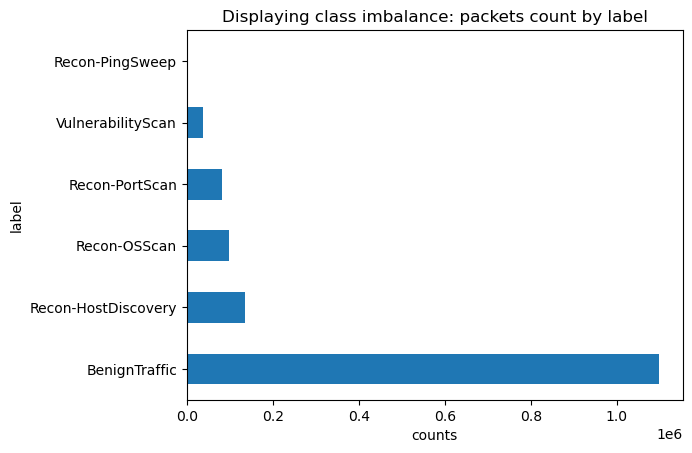

label
BenignTraffic          0.755940
Recon-HostDiscovery    0.092498
Recon-OSScan           0.067636
Recon-PortScan         0.056637
VulnerabilityScan      0.025732
Recon-PingSweep        0.001557
Name: count, dtype: float64

In [158]:
df['label'].value_counts().plot(kind='barh')
plt.title('Displaying class imbalance: packets count by label')
plt.xlabel('counts')

plt.show()

df['label'].value_counts()/df.shape[0]

A quick look is telling how class imbalance is present in the dataset: over 3/4 of the dataset is benign traffic.

We will treat this aspect later on with SMOTE.

Let's now look at general features of the packets. Let's start by duration: how are durations of the packets distributed? How do benign vs malicious traffic compare?

Text(0.5, 1.0, 'Packet Duration Distribution: benign traffic vs reconattacks')

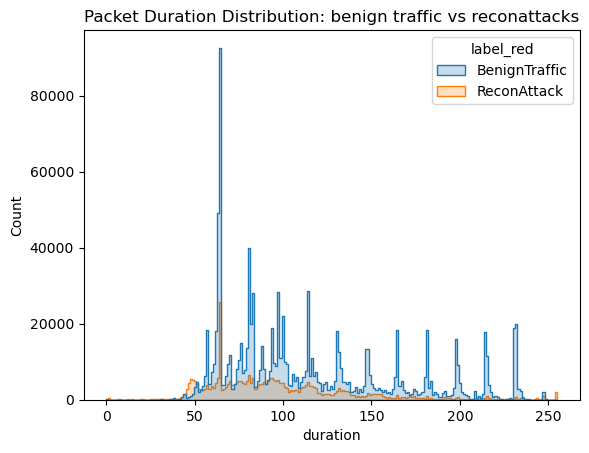

In [159]:
sns.histplot(df, x="duration", hue="label_red", element="step")
plt.title('Packet Duration Distribution: benign traffic vs reconattacks')

From the histogram we can see that:

- Recon Attacks and Benign Traffic have similar distributions
- Benign Traffic has more "spikes", as if the durations were clustered around certain values

Now let's look at distributions of duration across different cyberattacks with violin plots and ecdf

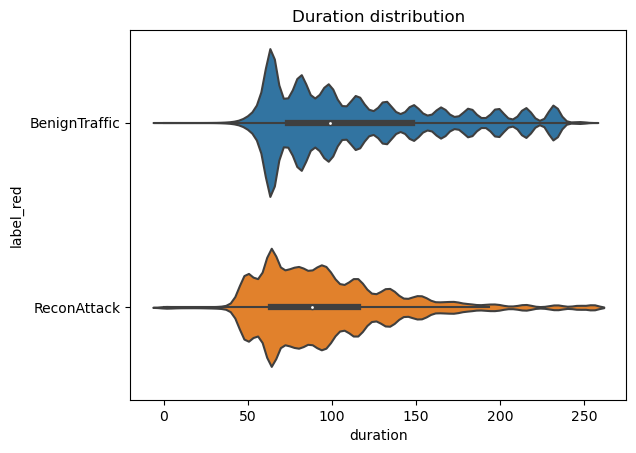

In [162]:
sns.violinplot(data = df , x='duration', y='label_red')
plt.title('Duration distribution')
plt.show()

Text(0.5, 1.0, 'ecdf of duration by kind of traffic')

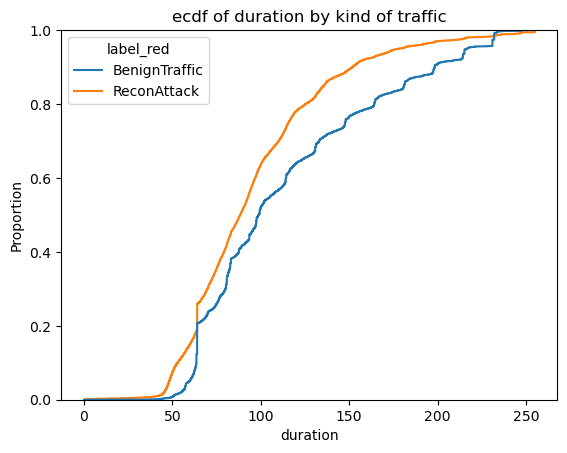

In [119]:
sns.ecdfplot(data=df, x="duration", hue="label_red")
plt.title('ecdf of duration by kind of traffic')

From the charts we can see that:

- Benign traffic has higher median duration
- Again we have in both ecdf and violin plots that characteristic "waivy" pattern in the distribution. Yet in recon attack that pattern is less pronounced.

Now let's take a look at how duration changes across different protocol types

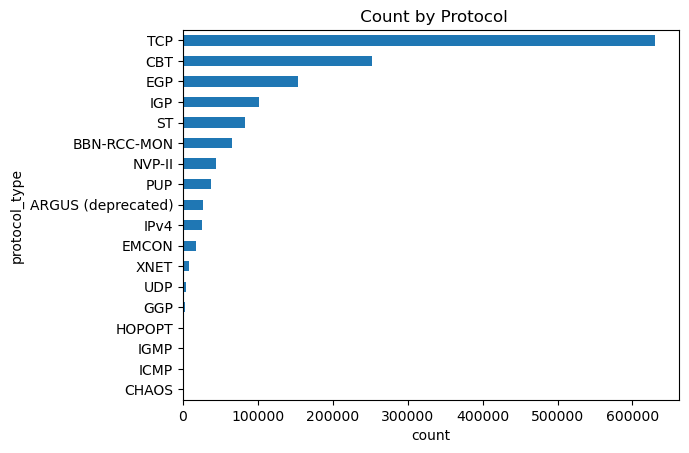

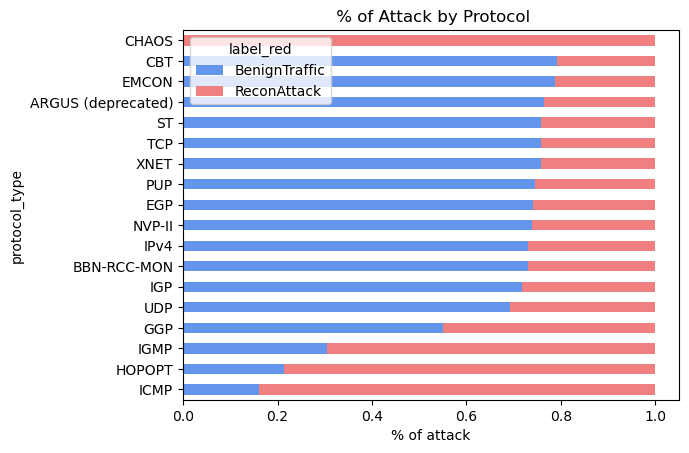

In [114]:
df.groupby('protocol_type')['duration'].count().sort_values().plot(kind='barh')
plt.title(' Count by Protocol')
plt.xlabel('count')

plt.show()

attack_rate = df.groupby(['protocol_type', 'label_red'])['label_red'].count()/df.groupby('protocol_type')['label_red'].count()
attack_rate.unstack()[['BenignTraffic', 'ReconAttack']].sort_values(by='BenignTraffic').plot(kind='barh', stacked=True, color=['cornflowerblue', 'lightcoral'])
plt.title(' % of Attack by Protocol')
plt.xlabel('% of attack')

plt.show()

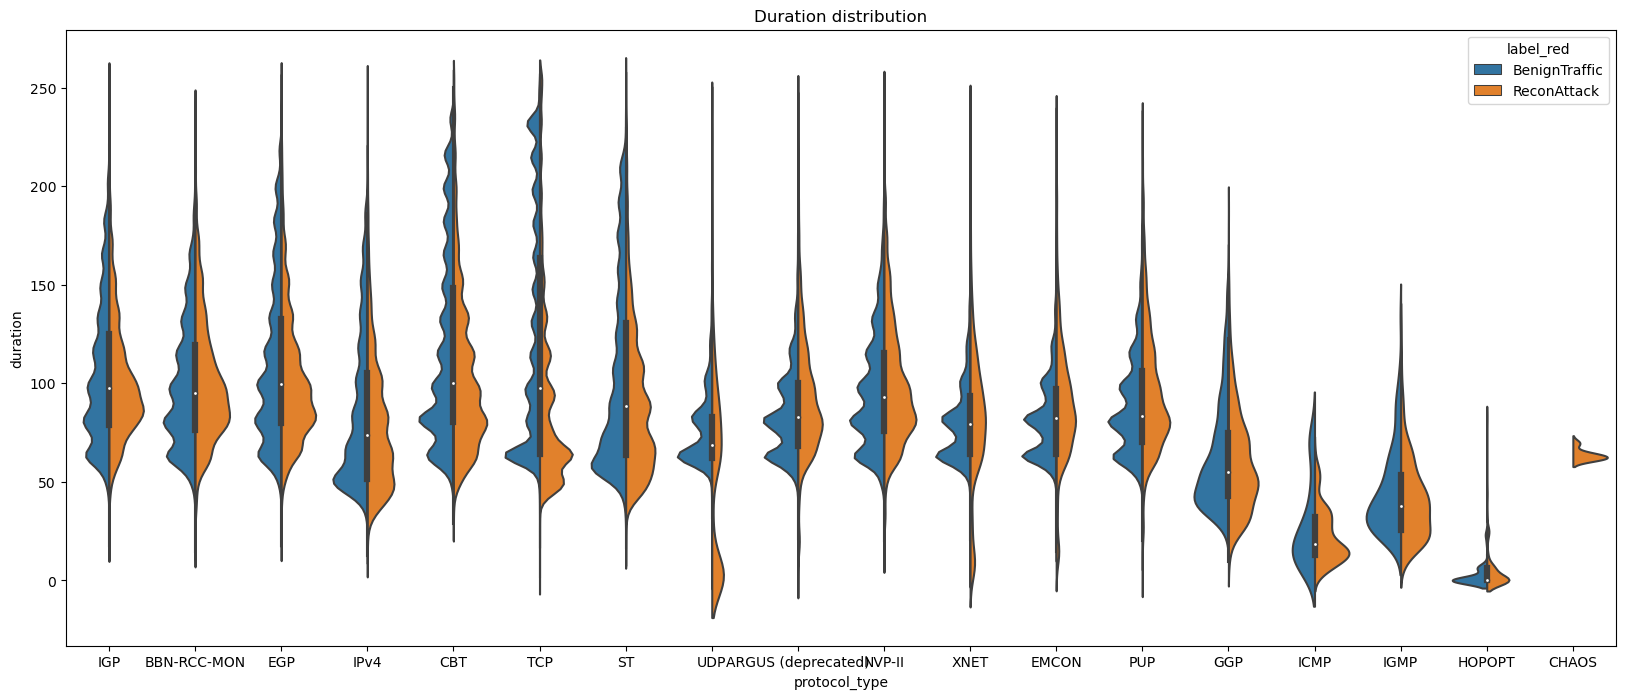

In [131]:
plt.figure(figsize=(20
                    ,8))

sns.violinplot(data = df , x='protocol_type', y='duration', hue='label_red', split=True)
plt.title('Duration distribution')
plt.show()

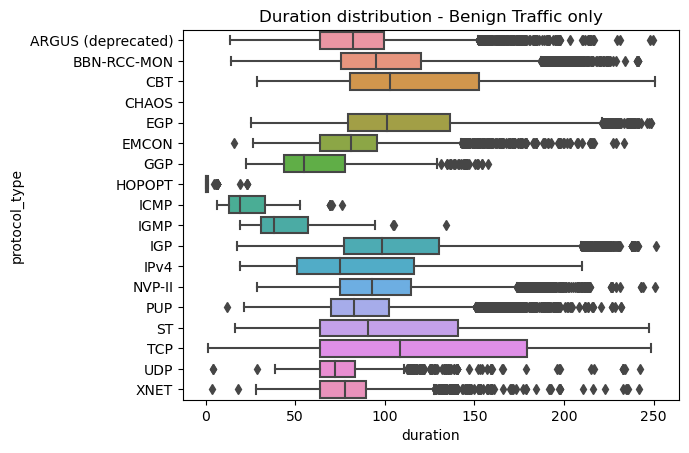

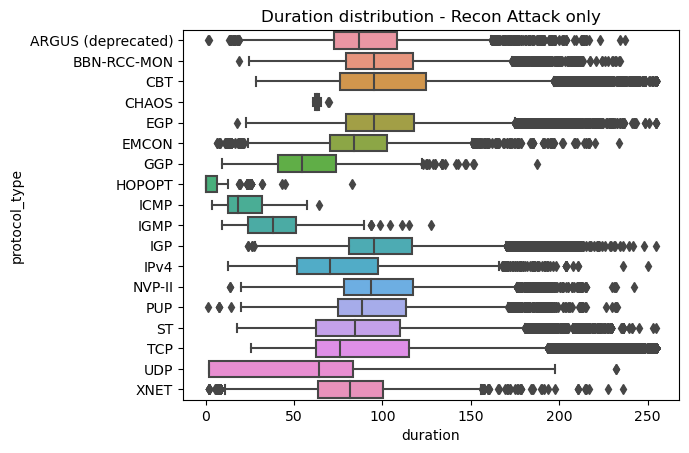

In [170]:
protocol_types_sort = df['protocol_type'].unique()
protocol_types_sort.sort()

sns.boxplot(data = df[df['label_red']=='BenignTraffic'] , x='duration', y='protocol_type', order=protocol_types_sort)
plt.title('Duration distribution - Benign Traffic only')
plt.show()

sns.boxplot(data = df[df['label_red']=='ReconAttack'] , x='duration', y='protocol_type', order=protocol_types_sort)
plt.title('Duration distribution - Recon Attack only')
plt.show()



The boxplots illustrate that benign traffic has a tighter duration distribution with fewer outliers compared to reconnaissance attack traffic, which shows increased variability and higher median durations, particularly for the 'ICMP' protocol. While benign traffic for 'TCP' and 'UDP' displays consistently low durations, the recon attack traffic reveals a broader spread across protocols, indicative of the varied tactics used in reconnaissance activities. The significant duration spread and outliers in 'ICMP' during recon attacks suggest extensive use of this protocol for activities such as ping sweeps and host discovery.


## Correlation analysis

Given the intricate patterns displayed already for duration, it's appropriate in this case to show a sythetic view of the relation between the numerical features and the target variables.

For the purpose of this notebook we will only cover correlation with the hot-encoded label_red column, which tells us weather the flow is part of a cyberattack or not.



In [173]:
# Hot encoded label_red
df['label_red_bin'] = df['label_red'].map({'BenignTraffic': 0, 'ReconAttack': 1})
df['label_red_bin'].value_counts()

label_red_bin
0    1098195
1     354560
Name: count, dtype: int64

In [176]:
df = pd.get_dummies(df, columns=['protocol_type'])

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1452755 entries, 0 to 1452759
Data columns (total 67 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   flow_duration                     1452755 non-null  float32
 1   header_length                     1452755 non-null  uint32 
 2   duration                          1452755 non-null  float32
 3   rate                              1452755 non-null  uint32 
 4   srate                             1452755 non-null  uint32 
 5   drate                             1452755 non-null  float32
 6   fin_flag_number                   1452755 non-null  bool   
 7   syn_flag_number                   1452755 non-null  bool   
 8   rst_flag_number                   1452755 non-null  bool   
 9   psh_flag_number                   1452755 non-null  bool   
 10  ack_flag_number                   1452755 non-null  bool   
 11  ece_flag_number                   1452755 

In [182]:
set(df.dtypes)

{dtype('bool'),
 dtype('uint16'),
 dtype('uint32'),
 dtype('int64'),
 dtype('float16'),
 dtype('float32'),
 dtype('O')}

In [183]:
# select numerical columns

df_numerical = df.select_dtypes(include=['bool','uint16','uint32','int64','float16','float32'])


In [184]:
corr = df_numerical.corr()


,flow_duration,header_length,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,protocol_type_ICMP,protocol_type_IGMP,protocol_type_IGP,protocol_type_IPv4,protocol_type_NVP-II,protocol_type_PUP,protocol_type_ST,protocol_type_TCP,protocol_type_UDP,protocol_type_XNET
flow_duration,1.000000,-0.027920,-0.019445,-0.002373,-0.002373,NaN,-0.000437,-0.016163,-0.013373,0.001387,...,-0.000570,0.000467,0.019204,-0.001224,0.021160,0.020623,-0.004440,-0.049708,0.022854,0.020096
header_length,-0.027920,1.000000,0.227536,-0.036715,-0.036715,NaN,-0.009422,-0.127530,-0.102420,-0.055867,...,-0.008936,-0.010231,-0.089669,-0.029703,-0.081547,-0.085116,-0.007853,0.235373,-0.031309,-0.045992
duration,-0.019445,0.227536,1.000000,-0.037436,-0.037436,NaN,-0.012890,-0.182228,0.020869,0.041386,...,-0.025204,-0.023603,-0.034424,-0.069304,-0.047225,-0.063928,-0.043695,0.130117,-0.042903,-0.046505
rate,-0.002373,-0.036715,-0.037436,1.000000,1.000000,NaN,-0.001049,-0.014039,-0.010953,-0.005776,...,0.000904,0.000053,0.027354,-0.007659,0.031138,0.034091,-0.016054,-0.056580,0.036929,0.034146
srate,-0.002373,-0.036715,-0.037436,1.000000,1.000000,NaN,-0.001049,-0.014039,-0.010953,-0.005776,...,0.000904,0.000053,0.027354,-0.007659,0.031138,0.034091,-0.016054,-0.056580,0.036929,0.034146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
protocol_type_PUP,0.020623,-0.085116,-0.063928,0.034091,0.034091,NaN,-0.002434,-0.032629,-0.026348,-0.022187,...,-0.002353,-0.002810,-0.044974,-0.021928,-0.028931,1.000000,-0.040084,-0.143388,-0.008669,-0.012572
protocol_type_ST,-0.004440,-0.007853,-0.043695,-0.016054,-0.016054,NaN,-0.002237,-0.005982,-0.006609,0.008863,...,-0.003519,-0.004203,-0.067269,-0.032799,-0.043274,-0.040084,1.000000,-0.214471,-0.012967,-0.018805
protocol_type_TCP,-0.049708,0.235373,0.130117,-0.056580,-0.056580,NaN,0.012207,0.162132,0.132047,0.048498,...,-0.012588,-0.015036,-0.240634,-0.117327,-0.154797,-0.143388,-0.214471,1.000000,-0.046386,-0.067267
protocol_type_UDP,0.022854,-0.031309,-0.042903,0.036929,0.036929,NaN,-0.000787,-0.010556,-0.008524,-0.007177,...,-0.000761,-0.000909,-0.014549,-0.007094,-0.009359,-0.008669,-0.012967,-0.046386,1.000000,-0.004067


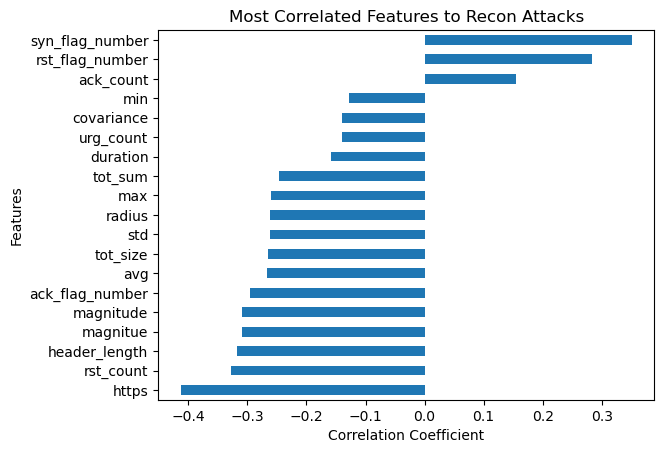

In [187]:
filtered_corr = corr[(corr['label_red_bin'] > 0.1) | (corr['label_red_bin'] < -0.1)]

# Exclude values exactly equal to 1
filtered_corr = filtered_corr[filtered_corr['label_red_bin'] != 1]

# Sort the values by the 'label_red_bin' column
sorted_corr = filtered_corr.sort_values('label_red_bin', ascending=True)

# Now plot the sorted, filtered correlations
sorted_corr[['label_red_bin']].plot(kind='barh', legend=False)

plt.title('Most Correlated Features to Recon Attacks')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

The features syn_flag_number, rst_flag_number, and ack_count have the strongest positive correlation, suggesting that as these values increase, so does the likelihood of the traffic being related to recon attacks. 

Notably, the feature https is negatively correlated, indicating that higher https traffic might be associated with lower instances of recon attacks, potentially due to the encrypted nature of HTTPS reducing the effectiveness of such attacks.

The absence of any features with a correlation coefficient greater than 0.3 or less than -0.4 suggests that while these features have some relationship with reconnaissance activities, they are not perfect predictor

## Next Steps:

- Scaling the dataset
- Dealing with class unbalance
- PCA

After this we will test different models effectiveness.s.